In [1]:
# importing necessary packages
import numpy as np
import pandas as pd
import yfinance as yf

### Data Acquisition

In [2]:
# Downloading data using yfinance
exchange_rates = yf.download('PLN=X', start='2012-01-01', end='2024-05-31')
stock_prices = yf.download('^WIG', start='2012-01-01', end='2024-05-31')
gold_prices = yf.download('GC=F', start='2012-01-01', end='2024-05-31')

# Renaming columns for clarity
exchange_rates.rename(columns={'Adj Close': 'Exchange Rate'}, inplace=True)
stock_prices.rename(columns={'Adj Close': 'Stock Price'}, inplace=True)
gold_prices.rename(columns={'Adj Close': 'Gold Price'}, inplace=True)

# Keeping only the relevant columns
exchange_rates = exchange_rates[['Exchange Rate']]
stock_prices = stock_prices[['Stock Price']]
gold_prices = gold_prices[['Gold Price']]

# Merging dataframes on the date
data = exchange_rates.join([stock_prices, gold_prices], how='inner')


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


### Exploratory Data Analysis (EDA)

In [3]:
data.head()

,Exchange Rate,Stock Price,Gold Price
Date,,,
2013-04-30,3.15720,44162.179688,1472.199951
2013-05-02,3.15980,43991.511719,1467.699951
2013-05-06,3.15374,44541.730469,1468.099976
2013-05-07,3.17228,44742.218750,1449.000000
2013-05-08,3.16340,45117.941406,1473.900024


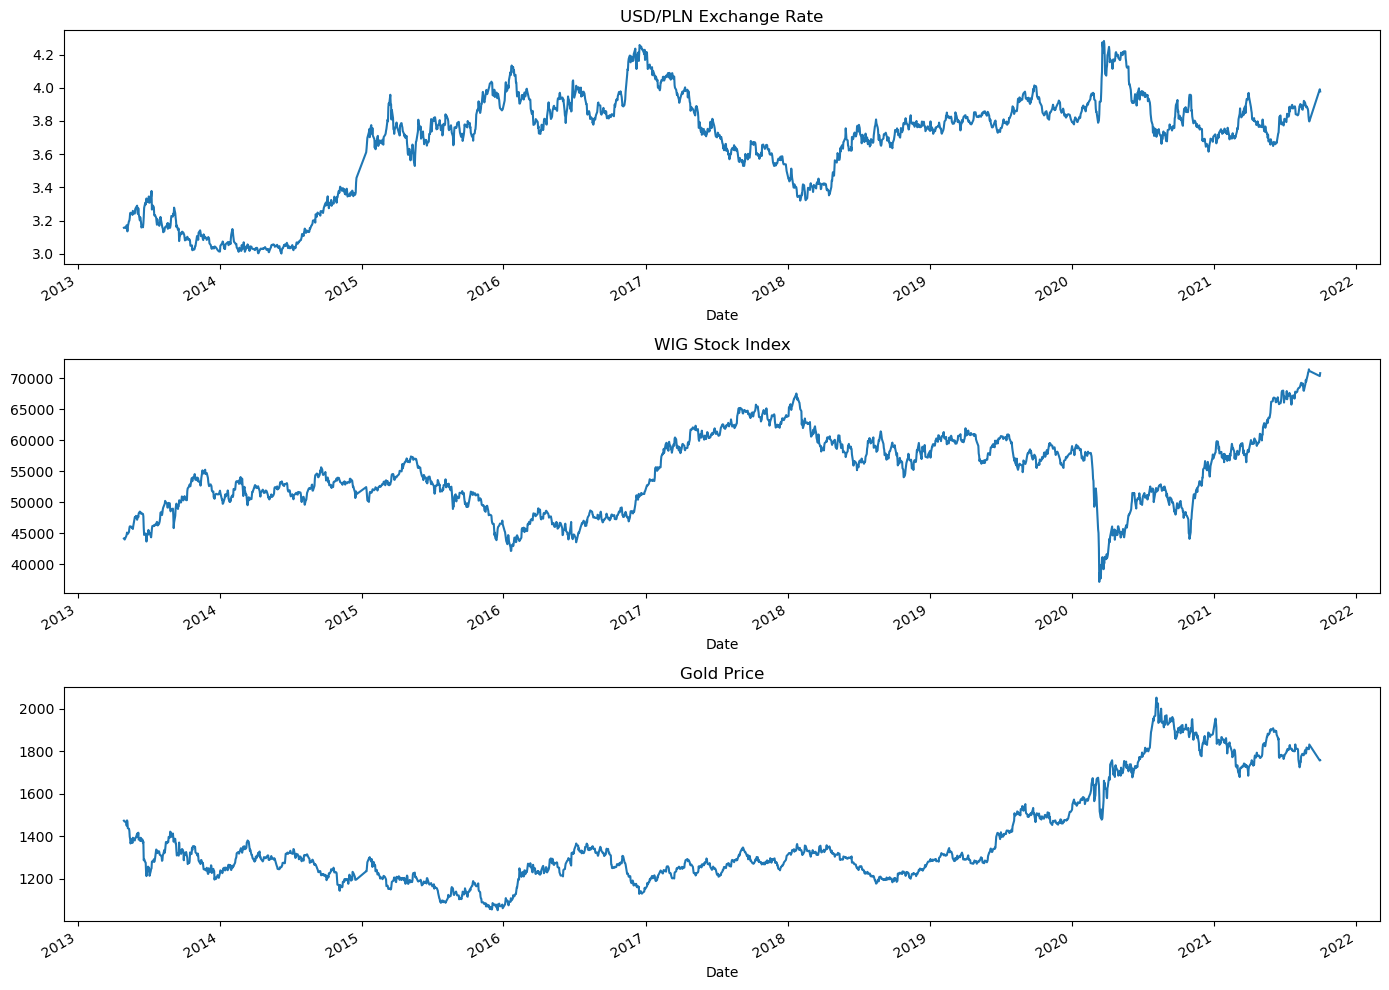

,Exchange Rate,Stock Price,Gold Price
count,2018.000000,2018.000000,2018.000000
mean,3.674712,54675.187223,1376.141576
std,0.306235,6130.288291,228.577647
min,3.001700,37164.019531,1050.800049
25%,3.559270,50361.589844,1229.099976
50%,3.758150,54093.320312,1291.750000
75%,3.871620,59320.243164,1463.099976
max,4.282000,71431.156250,2051.500000


In [4]:
import matplotlib.pyplot as plt

# Plotting the time series
fig, ax = plt.subplots(3, 1, figsize=(14, 10))
data['Exchange Rate'].plot(ax=ax[0], title='USD/PLN Exchange Rate')
data['Stock Price'].plot(ax=ax[1], title='WIG Stock Index')
data['Gold Price'].plot(ax=ax[2], title='Gold Price')
plt.tight_layout()
plt.show()

# Descriptive statistics
descriptive_stats = data.describe()
descriptive_stats


### Train- Test Split

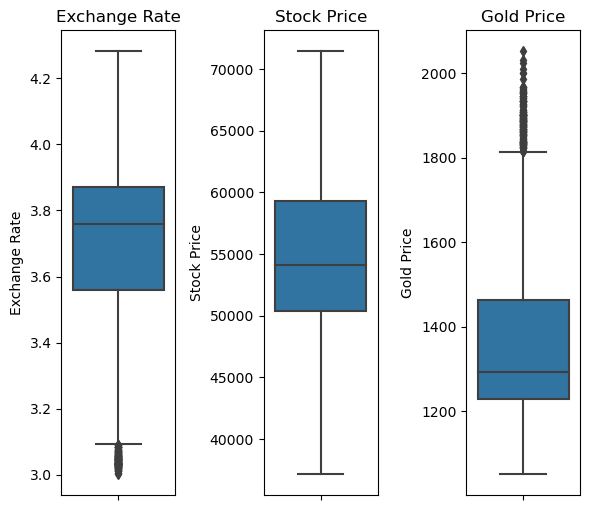

In [5]:
import seaborn as sns

number_of_columns = len(data.columns)
plt.figure(figsize=(2 * number_of_columns, 10))

for i, column in enumerate(data.columns):
    if pd.api.types.is_numeric_dtype(data[column]):
        plt.subplot(2, number_of_columns, i + 1)
        sns.boxplot(y=data[column])
        plt.title(column)

plt.tight_layout()
plt.show()

In [6]:
import numpy as np

def treat_outliers_iqr(data, column, factor=1.5):
    # Calculate Q1 and Q3
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    
    # Calculate IQR
    IQR = Q3 - Q1
    
    # Define upper and lower bounds
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    
    # Identify outliers
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    
    # Treat outliers
    data.loc[outliers.index, column] = np.nan
    
    return data

df_cleaned = treat_outliers_iqr(data, 'Exchange Rate')

df_cleaned.dropna(inplace=True)

print("Outliers treated in 'Exchange Rate' column:")
print(df_cleaned.describe())


Outliers treated in 'Exchange Rate' column:
       Exchange Rate   Stock Price   Gold Price
count    1848.000000   1848.000000  1848.000000
mean        3.732724  54927.438138  1383.794372
std         0.249811   6337.902113   237.110184
min         3.091380  37164.019531  1050.800049
25%         3.654333  49892.000977  1224.500000
50%         3.773685  55611.679688  1290.299988
75%         3.882950  59587.005859  1490.049988
max         4.282000  71431.156250  2051.500000


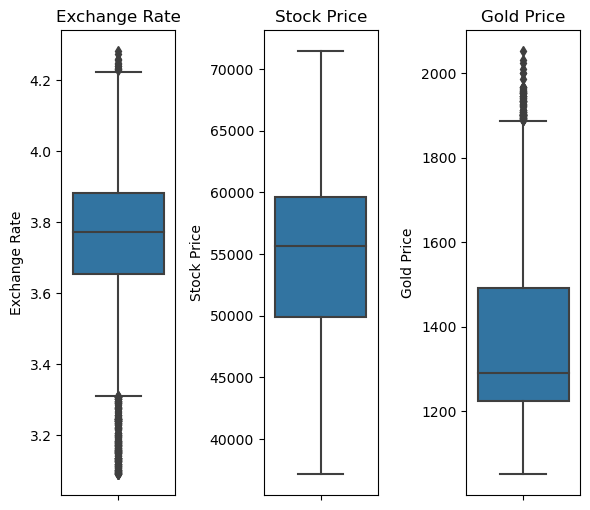

In [7]:
number_of_columns = len(df_cleaned.columns)
plt.figure(figsize=(2 * number_of_columns, 10))

for i, column in enumerate(df_cleaned.columns):
    if pd.api.types.is_numeric_dtype(df_cleaned[column]):
        plt.subplot(2, number_of_columns, i + 1)
        sns.boxplot(y=df_cleaned[column])
        plt.title(column)

plt.tight_layout()
plt.show()

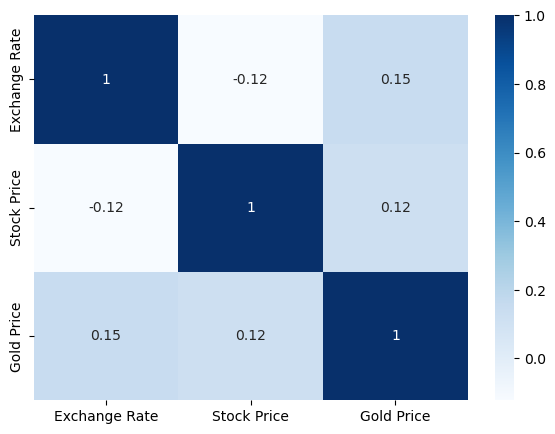

In [8]:
df = df_cleaned
cols = df.columns
corr = df[cols].corr()
plt.figure(figsize = (7,5))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, annot=True, cmap='Blues');

In [9]:
# Split the data into training (90%) and test sets (10%)
train_size = int(len(df) * 0.9)
train, test = df[:train_size], df[train_size:]

# Display the sizes of training and test sets
print(f'Train size: {len(train)}, Test size: {len(test)}')


Train size: 1663, Test size: 185


In [10]:
# Log transformation for stabilization 
data_log = np.log(data)

### Stationarity Analysis

/var/folders/sv/dscnvm7n1kj2h6vjg_k93vpm0000gn/T/ipykernel_59478/72036254.py:11: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


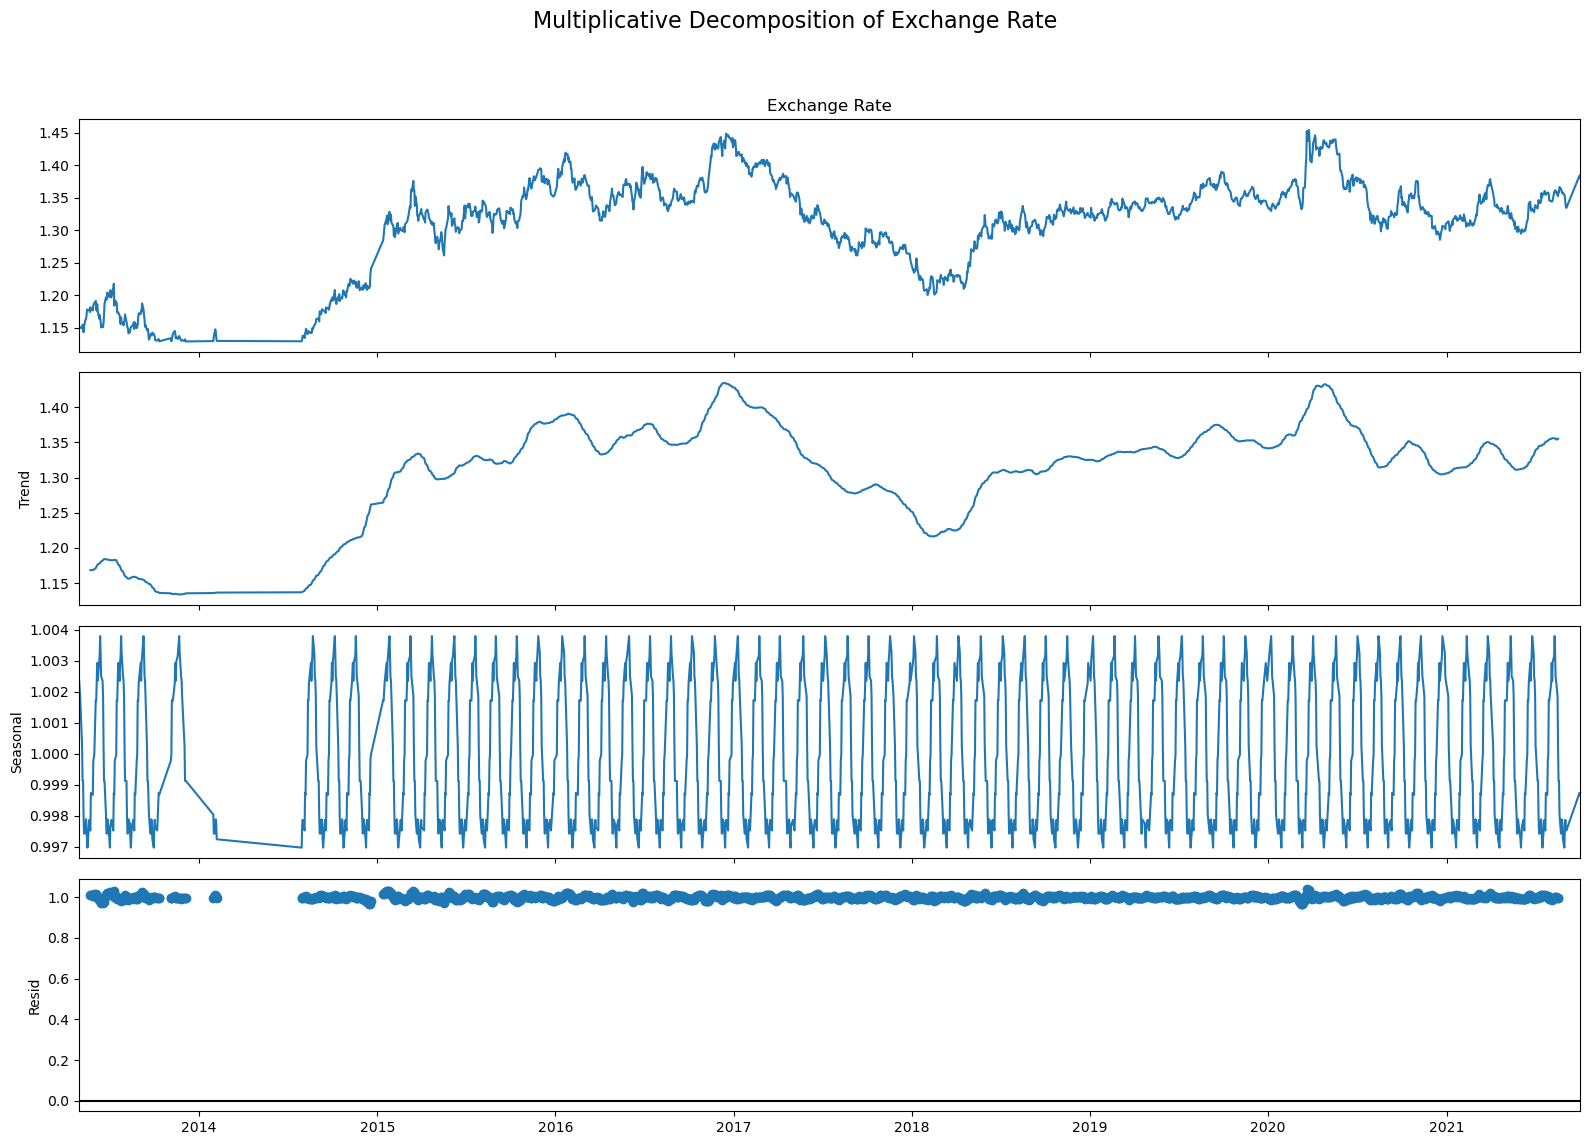

/var/folders/sv/dscnvm7n1kj2h6vjg_k93vpm0000gn/T/ipykernel_59478/72036254.py:11: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


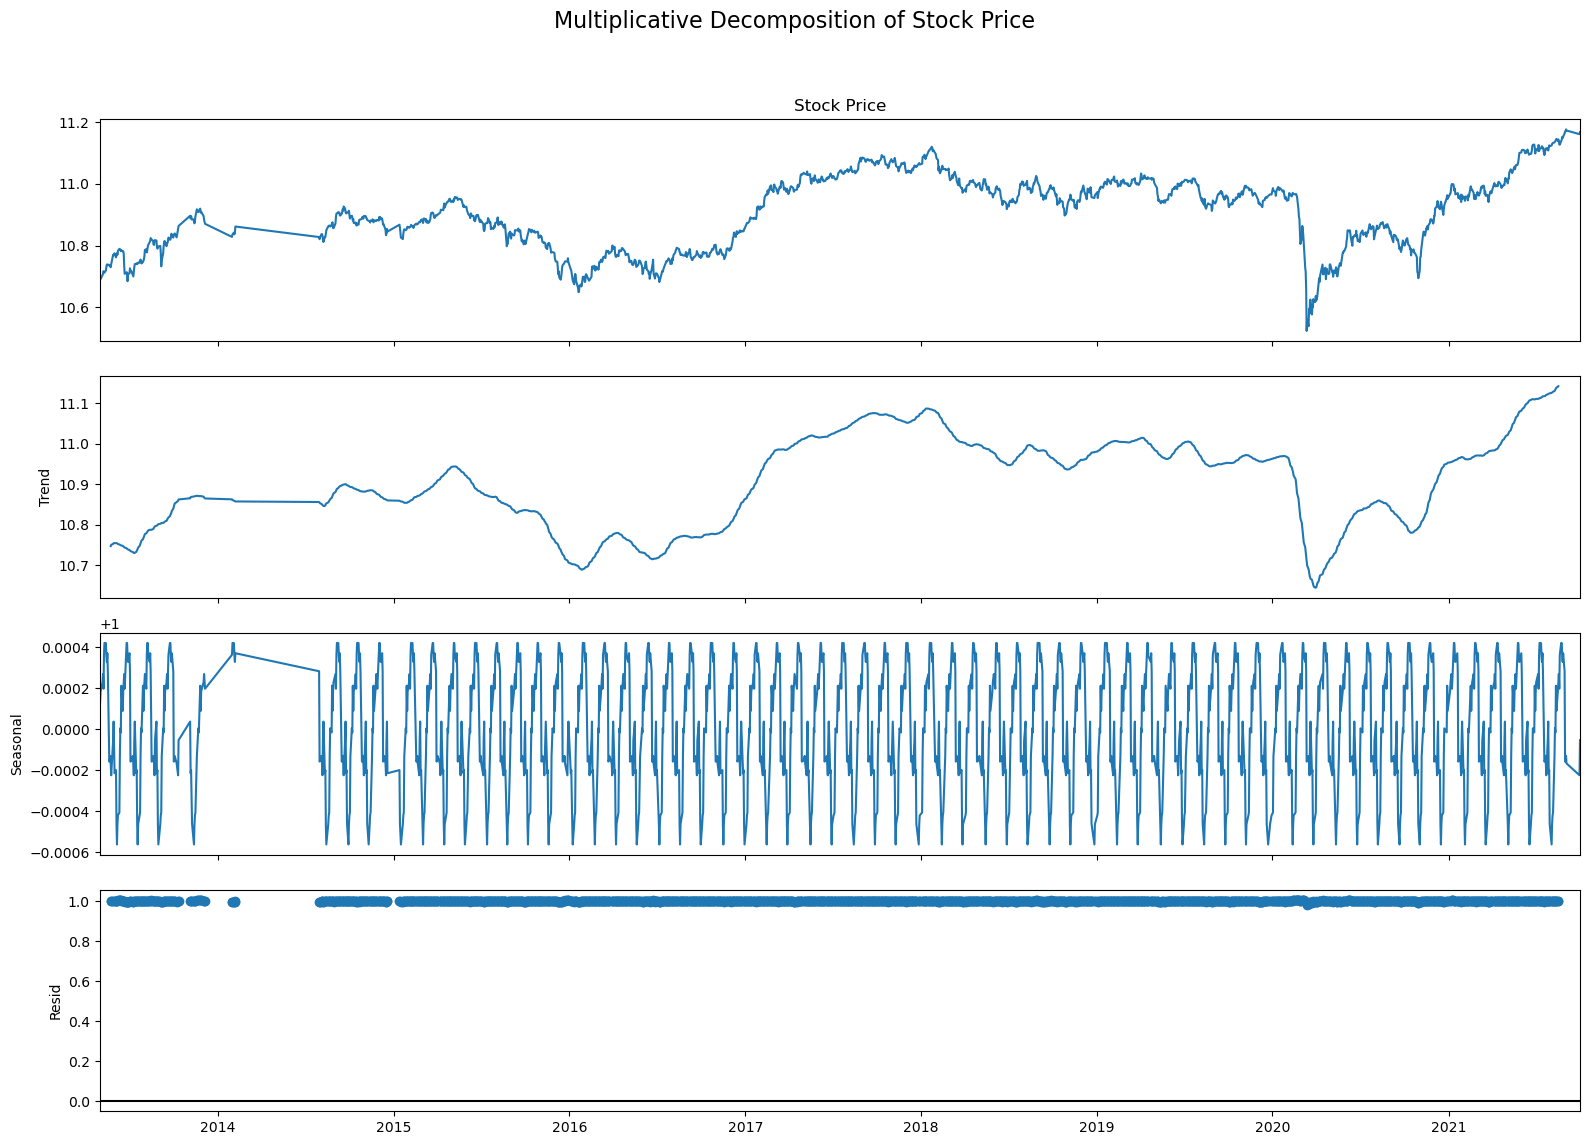

/var/folders/sv/dscnvm7n1kj2h6vjg_k93vpm0000gn/T/ipykernel_59478/72036254.py:11: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


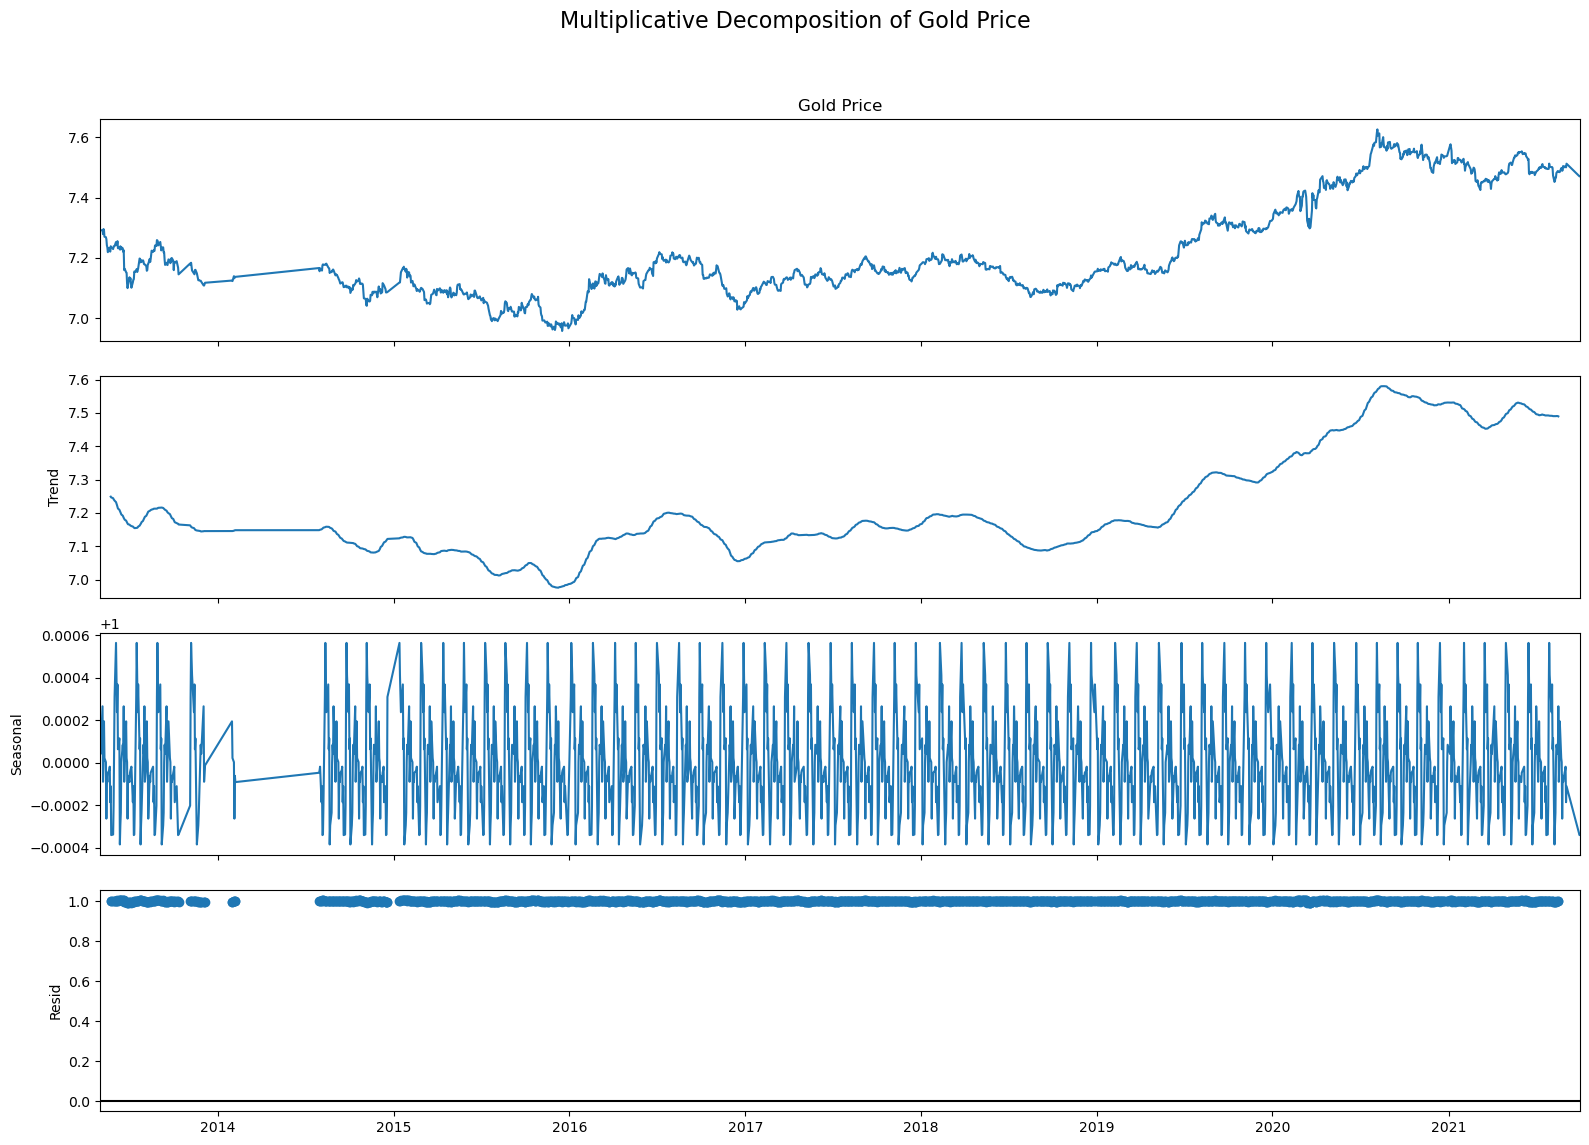

In [11]:
# Multiplicative Decomposition 
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
import matplotlib.pyplot as plt

def decompose_and_plot(data, column):
    decomposition = seasonal_decompose(data[column], model='multiplicative', period=30)
    plt.rcParams.update({'figure.figsize': (16, 12)})
    decomposition.plot().suptitle(f'Multiplicative Decomposition of {column}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

columns_to_decompose = ['Exchange Rate', 'Stock Price', 'Gold Price']
for column in columns_to_decompose:
    decompose_and_plot(data_log, column)


plt.show()

/var/folders/sv/dscnvm7n1kj2h6vjg_k93vpm0000gn/T/ipykernel_59478/3787058008.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


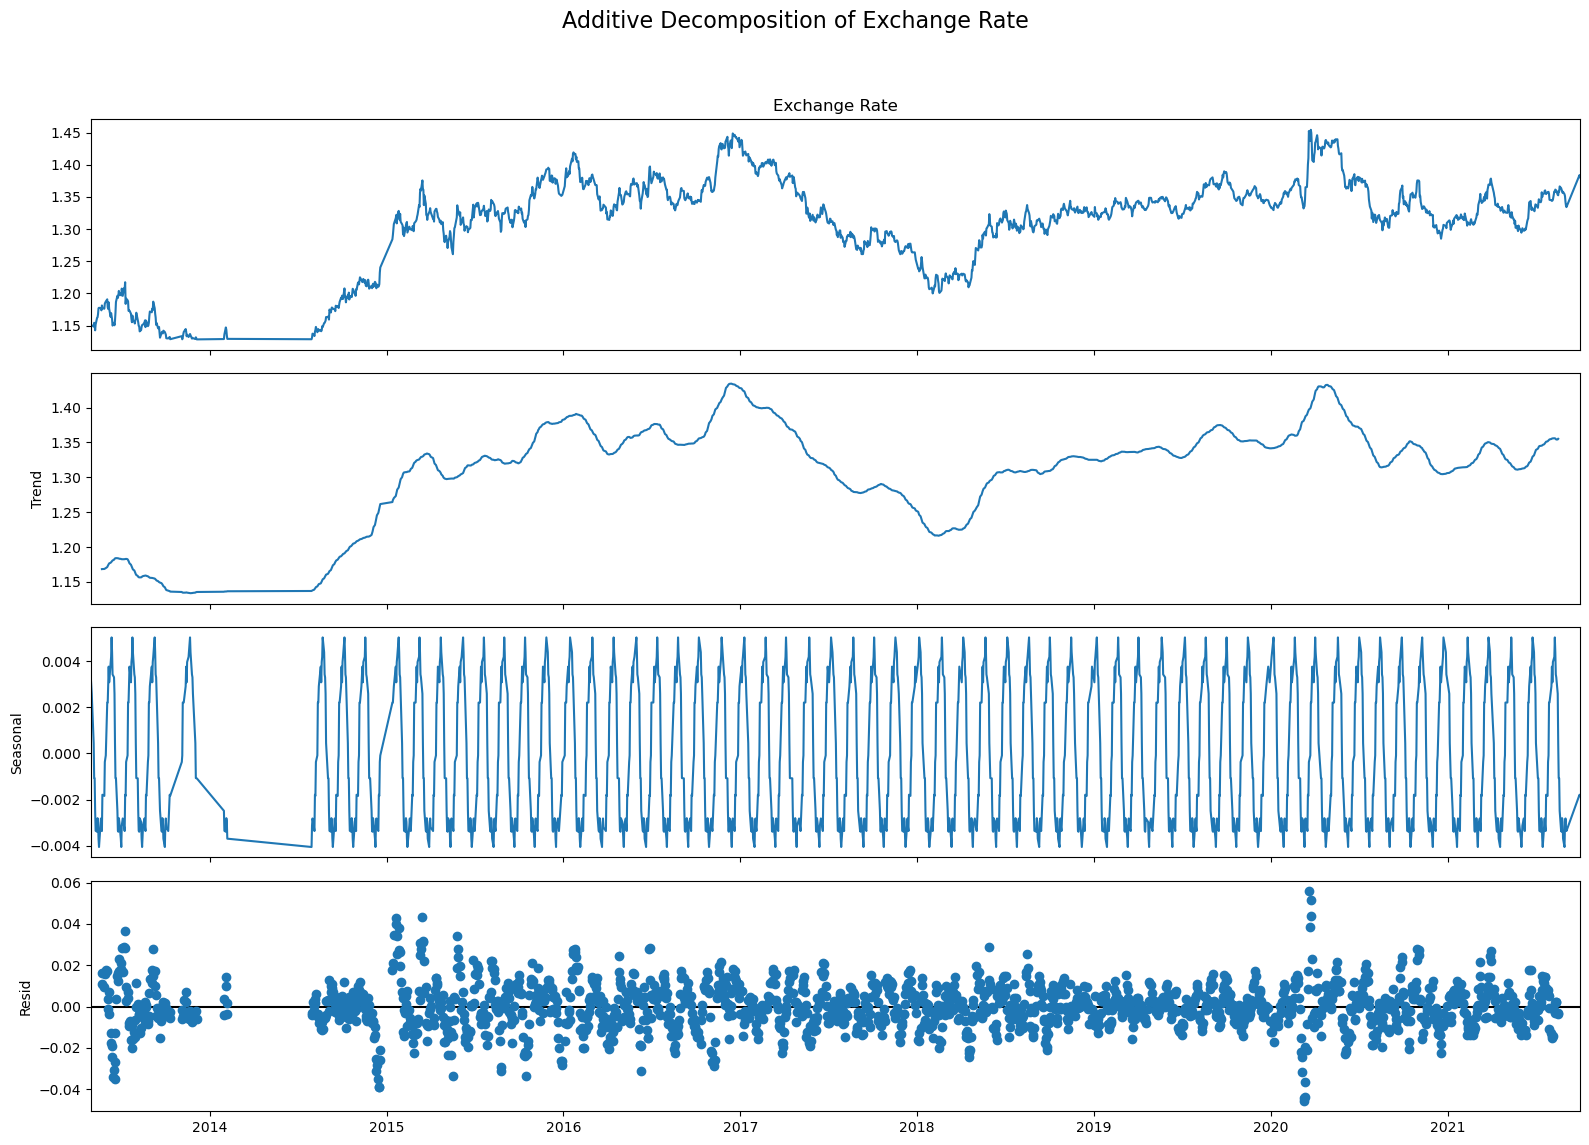

/var/folders/sv/dscnvm7n1kj2h6vjg_k93vpm0000gn/T/ipykernel_59478/3787058008.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


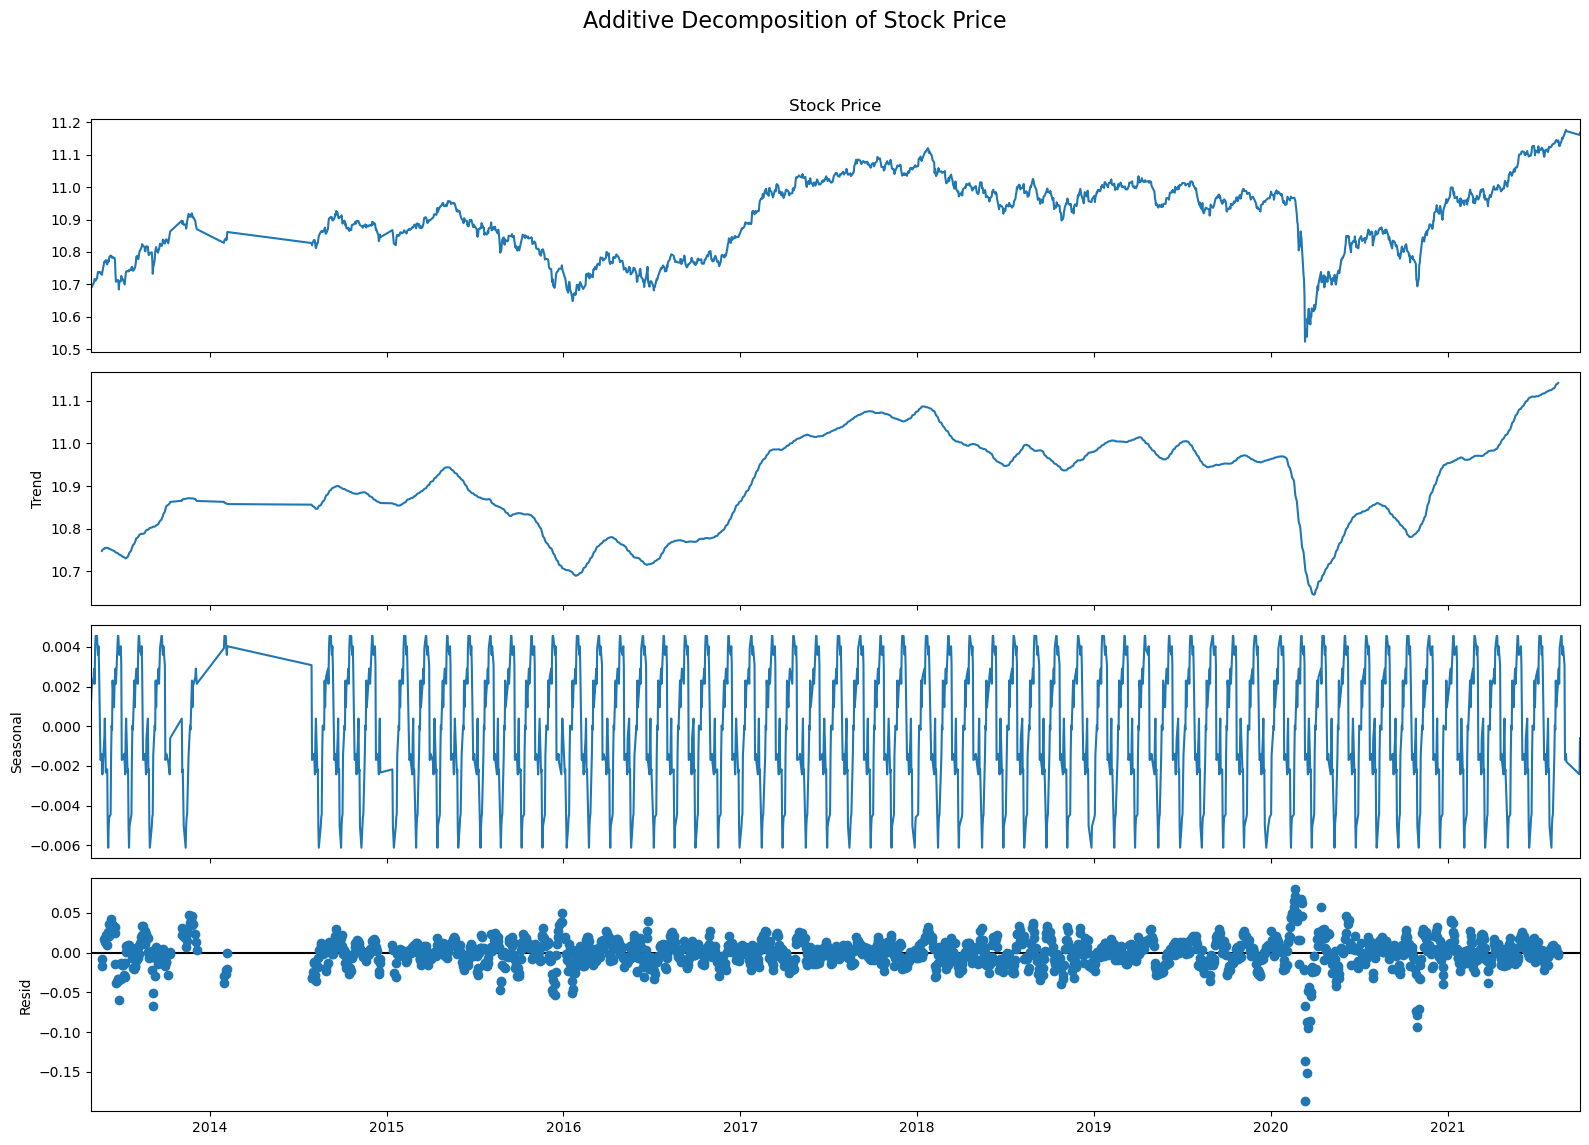

/var/folders/sv/dscnvm7n1kj2h6vjg_k93vpm0000gn/T/ipykernel_59478/3787058008.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


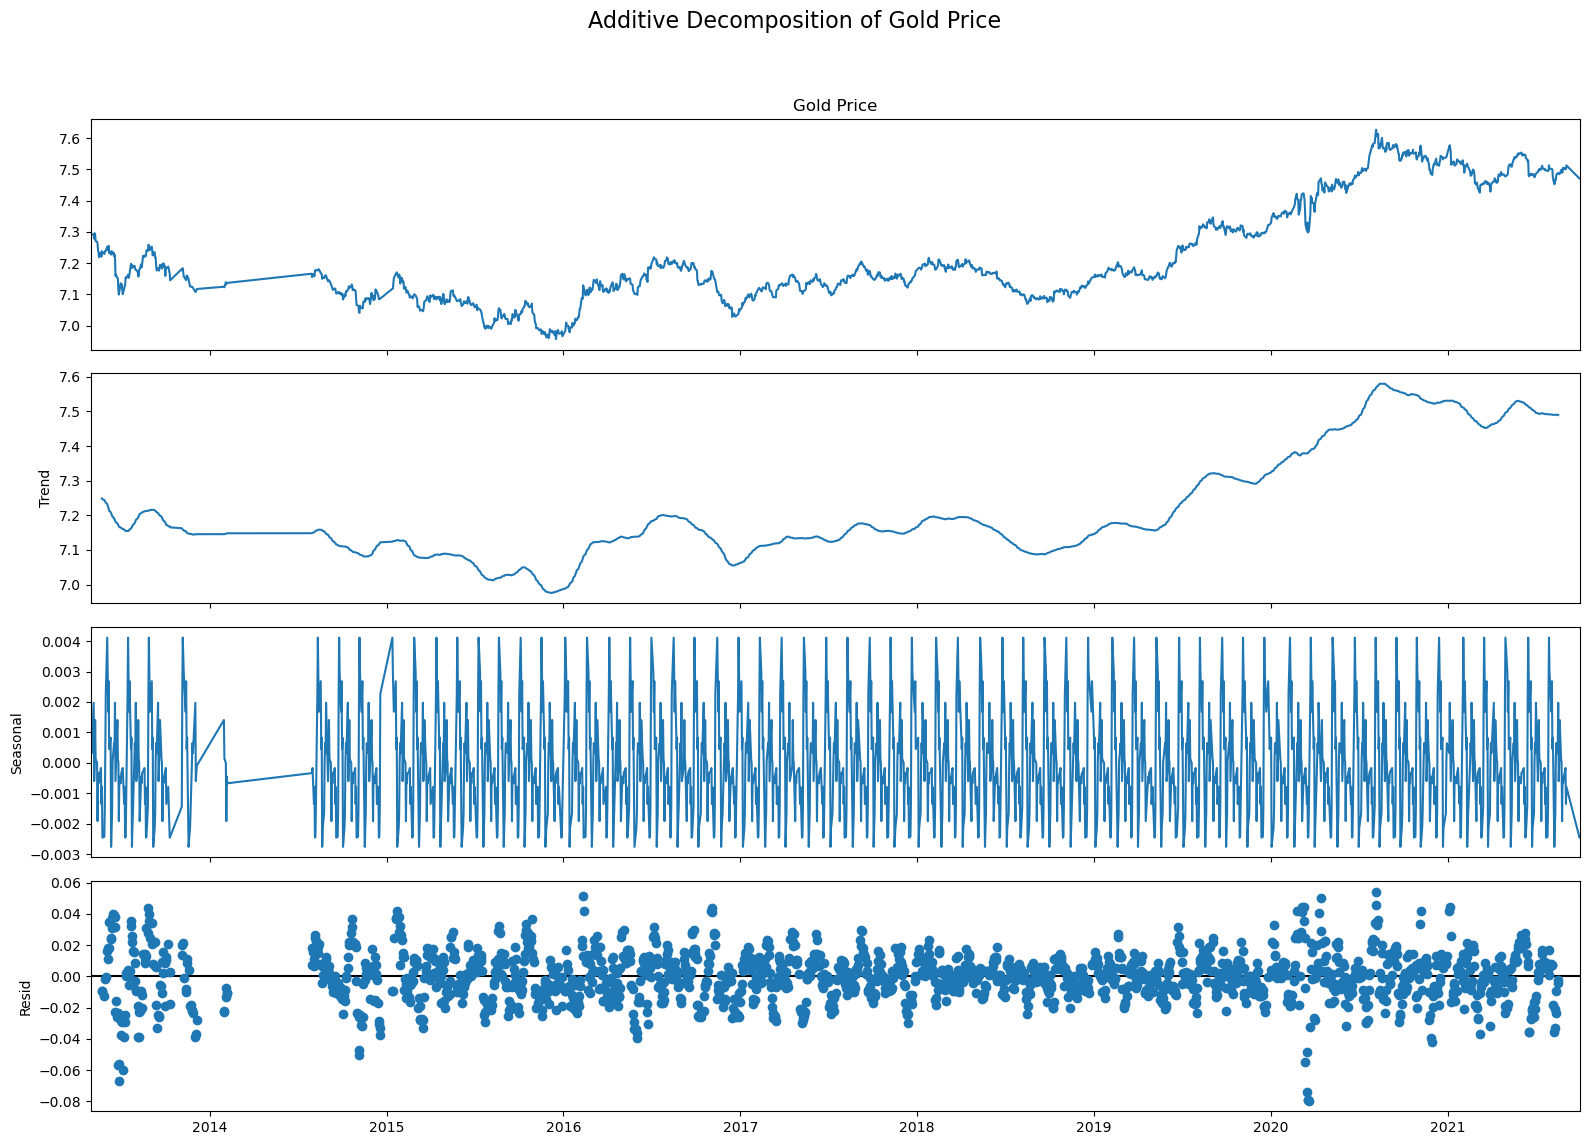

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
import matplotlib.pyplot as plt

def decompose_and_plot(data, column):
    decomposition = seasonal_decompose(data[column], model='additive', period=30)
    plt.rcParams.update({'figure.figsize': (16, 12)})
    decomposition.plot().suptitle(f'Additive Decomposition of {column}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

columns_to_decompose = ['Exchange Rate', 'Stock Price', 'Gold Price']
for column in columns_to_decompose:
    decompose_and_plot(data_log, column)

In [13]:
from statsmodels.tsa.stattools import adfuller, kpss 

# Stationarity tests
def stationarity_tests(series):
    # ADF Test
    adf_result = adfuller(series)
    adf_p_value = adf_result[1]

    print(f'ADF Statistic: {adf_result[0]}')
    print(f'p-value: {adf_result[1]}')
    
    # KPSS Test
    kpss_result = kpss(series, regression='c')
    kpss_p_value = kpss_result[1]

    print(f'KPSS Statistic: {kpss_result[0]}')
    print(f'p-value: {kpss_result[1]}')

    if adf_p_value < 0.05 and kpss_p_value > 0.05:
        print("The time series is stationary (according to ADF test) but not trend stationary (according to KPSS test).")
    elif adf_p_value > 0.05 and kpss_p_value < 0.05:
        print("The time series is trend stationary (according to KPSS test) but not stationary (according to ADF test).")
    elif adf_p_value < 0.05 and kpss_p_value < 0.05:
        print("The time series is stationary (according to both ADF and KPSS tests).")
    else:
        print("The time series is not stationary.")
        print("Consider further analysis or differencing to achieve stationarity.")

for column in data_log.columns:
    print(f'\nStationarity test for {column}')
    stationarity_tests(data_log[column])



Stationarity test for Exchange Rate
ADF Statistic: -2.6820596849158758
p-value: 0.0771945089806162
KPSS Statistic: 1.655607829992594
p-value: 0.01
The time series is trend stationary (according to KPSS test) but not stationary (according to ADF test).

Stationarity test for Stock Price
ADF Statistic: -2.209169115309388
p-value: 0.2029344441809522
KPSS Statistic: 1.5636912311512337
p-value: 0.01
The time series is trend stationary (according to KPSS test) but not stationary (according to ADF test).

Stationarity test for Gold Price
ADF Statistic: -0.924043209881476
p-value: 0.7799515719350415
KPSS Statistic: 4.5250489787812835
p-value: 0.01
The time series is trend stationary (according to KPSS test) but not stationary (according to ADF test).


/var/folders/sv/dscnvm7n1kj2h6vjg_k93vpm0000gn/T/ipykernel_59478/1940902816.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series, regression='c')
/var/folders/sv/dscnvm7n1kj2h6vjg_k93vpm0000gn/T/ipykernel_59478/1940902816.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series, regression='c')
/var/folders/sv/dscnvm7n1kj2h6vjg_k93vpm0000gn/T/ipykernel_59478/1940902816.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series, regression='c')


In [14]:
df_diff = data_log.diff().dropna()
df_log_diff = data_log.apply(lambda x: np.log(x)).diff().dropna()

# Perform stationarity tests again 
for column in df_diff.columns:
    print(f'\nStationarity test for differenced {column}')
    stationarity_tests(df_diff[column])



Stationarity test for differenced Exchange Rate
ADF Statistic: -18.24601701056129
p-value: 2.348886098270756e-30
KPSS Statistic: 0.08127238775807487
p-value: 0.1
The time series is stationary (according to ADF test) but not trend stationary (according to KPSS test).

Stationarity test for differenced Stock Price


/var/folders/sv/dscnvm7n1kj2h6vjg_k93vpm0000gn/T/ipykernel_59478/1940902816.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c')
/var/folders/sv/dscnvm7n1kj2h6vjg_k93vpm0000gn/T/ipykernel_59478/1940902816.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c')


ADF Statistic: -10.882373375474048
p-value: 1.2851118049043772e-19
KPSS Statistic: 0.07592960350142723
p-value: 0.1
The time series is stationary (according to ADF test) but not trend stationary (according to KPSS test).

Stationarity test for differenced Gold Price
ADF Statistic: -44.37616750839812
p-value: 0.0
KPSS Statistic: 0.23689719988331193
p-value: 0.1
The time series is stationary (according to ADF test) but not trend stationary (according to KPSS test).


/var/folders/sv/dscnvm7n1kj2h6vjg_k93vpm0000gn/T/ipykernel_59478/1940902816.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c')


In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(df_diff), columns=df_diff.columns, index=df_diff.index)

# Displaying the prepared data
print(data_scaled.head())

            Exchange Rate  Stock Price  Gold Price
Date                                              
2013-05-02       0.413250     0.685762    0.508397
2013-05-06       0.380381     0.770843    0.535337
2013-05-07       0.473626     0.729410    0.427315
2013-05-08       0.369794     0.749615    0.670817
2013-05-09       0.296466     0.685713    0.505126


### Model Selection and Model Fitting

In [16]:
# Split the data into training (90%) and test sets (10%)
train_size = int(len(data_scaled) * 0.9)
train, test = data_scaled[:train_size], data_scaled[train_size:]

# Display the sizes of training and test sets
print(f'Train size: {len(train)}, Test size: {len(test)}')

Train size: 1662, Test size: 185


In [17]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMAX model
sarimax_model = SARIMAX(train['Exchange Rate'], 
                        exog=train[['Stock Price', 'Gold Price']],
                        order=(1, 1, 1), 
                        seasonal_order=(1, 1, 1, 12)).fit()
sarimax_pred = sarimax_model.forecast(steps=len(test), exog=test[['Stock Price', 'Gold Price']])



/Users/suman/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suman/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.15978D-01    |proj g|=  3.07473D+00

At iterate    5    f= -8.73426D-01    |proj g|=  3.44170D-01

At iterate   10    f= -9.37371D-01    |proj g|=  1.16602D+00

At iterate   15    f= -1.00586D+00    |proj g|=  8.80746D-02

At iterate   20    f= -1.02061D+00    |proj g|=  3.56266D-01

At iterate   25    f= -1.05205D+00    |proj g|=  1.18568D-01

At iterate   30    f= -1.05518D+00    |proj g|=  2.33949D-02

At iterate   35    f= -1.05742D+00    |proj g|=  7.86087D-03

At iterate   40    f= -1.05760D+00    |proj g|=  6.13718D-02

At iterate   45    f= -1.05766D+00    |proj g|=  1.55907D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/suman/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/suman/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


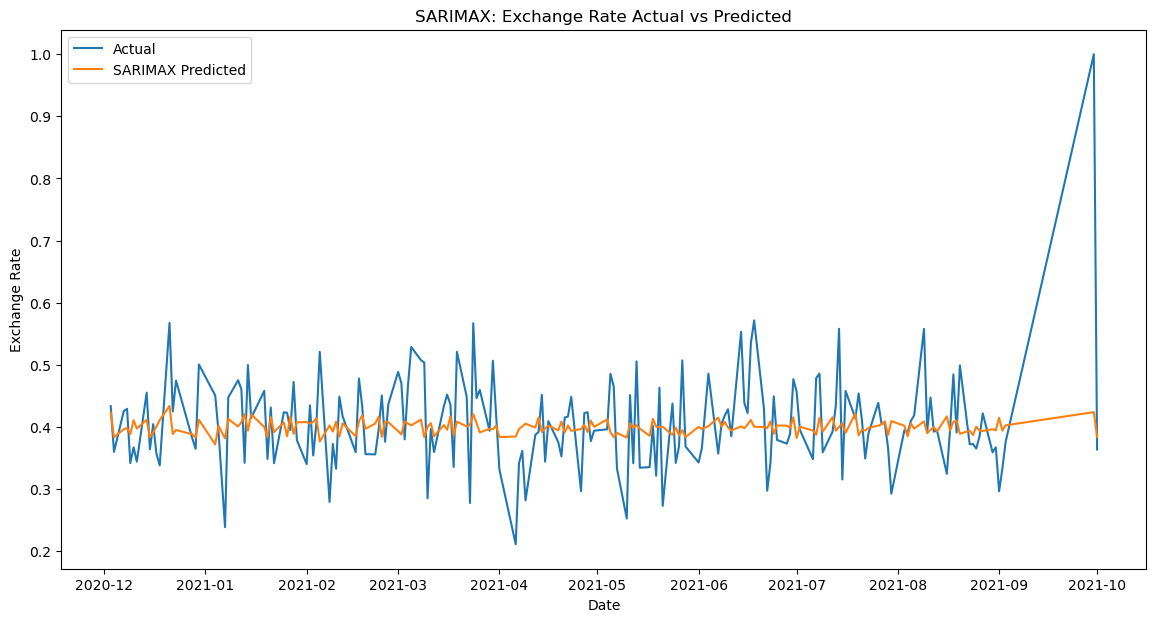

In [18]:
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(test.index, test['Exchange Rate'], label='Actual')
plt.plot(test.index, sarimax_pred, label='SARIMAX Predicted')
plt.title('SARIMAX: Exchange Rate Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

In [20]:
import itertools
from joblib import Parallel, delayed
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

aic_results = pd.DataFrame(columns=['param', 'param_seasonal', 'aic'])

def fit_sarimax(param, param_seasonal, train):
    try:
        mod = SARIMAX(train['Exchange Rate'],
                      exog=train[['Stock Prices', 'Gold Prices']],
                      order=param,
                      seasonal_order=param_seasonal,
                      enforce_stationarity=False,
                      enforce_invertibility=False)
        results = mod.fit(disp=False)
        return (param, param_seasonal, results.aic)
    except:
        return (param, param_seasonal, float('inf'))

results = Parallel(n_jobs=-1)(delayed(fit_sarimax)(param, param_seasonal, train) 
                              for param in pdq for param_seasonal in seasonal_pdq)

aic_results = pd.DataFrame(results, columns=['param', 'param_seasonal', 'aic'])
aic_results = aic_results.sort_values(by='aic')
best_params = aic_results.iloc[0]

In [21]:
sarimax_model = SARIMAX(train['Exchange Rate'],
                        exog=train[['Stock Price', 'Gold Price']],
                        order=best_params[0],
                        seasonal_order=best_params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False).fit()
sarimax_pred = sarimax_model.forecast(steps=len(test), exog=test[['Stock Price', 'Gold Price']])



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.21428D+00    |proj g|=  2.73193D-01

At iterate    5    f= -9.91706D-01    |proj g|=  6.30622D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6     29      1     0     0   6.306D-04  -9.917D-01
  F = -0.99170609010334942     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/suman/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suman/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/suman/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/suman/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported 

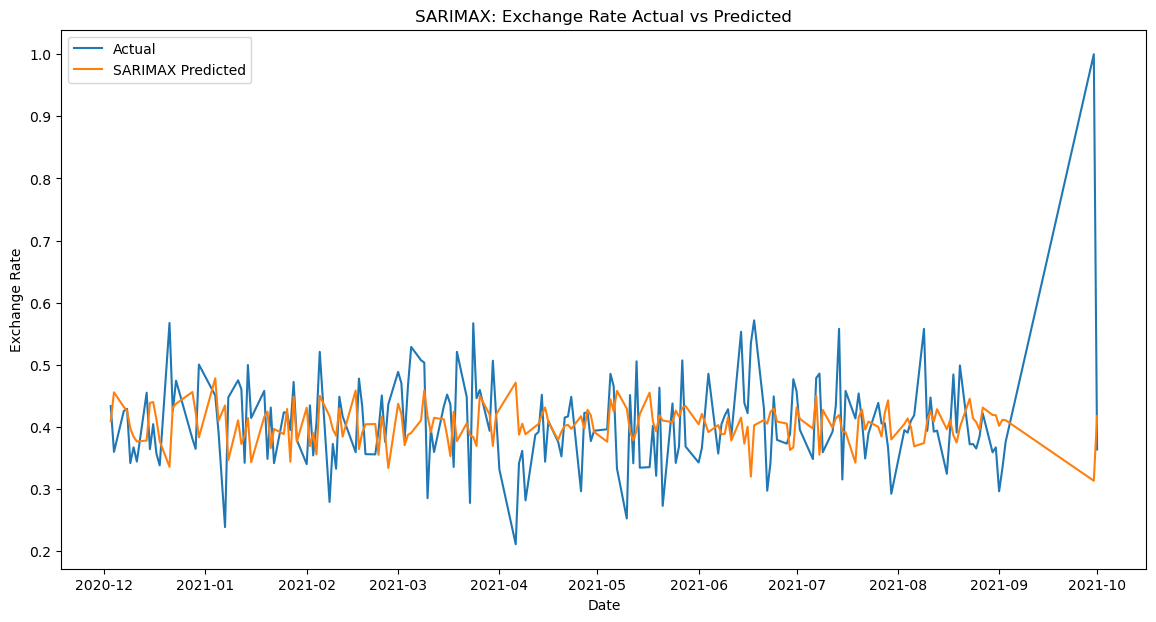

In [22]:
# plot the optimized sarimax
plt.figure(figsize=(14, 7))
plt.plot(test.index, test['Exchange Rate'], label='Actual')
plt.plot(test.index, sarimax_pred, label='SARIMAX Predicted')
plt.title('SARIMAX: Exchange Rate Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()


In [27]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.vector_ar.var_model import VAR

var_model = VAR(train.diff().dropna())
var_fit = var_model.fit(maxlags=15, ic='aic')

# Forecast for the test period
var_pred = var_fit.forecast(var_fit.endog, steps=len(test))

# Convert forecast to a DataFrame
var_pred_df = pd.DataFrame(var_pred, index=test.index, columns=train.columns)




/Users/suman/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


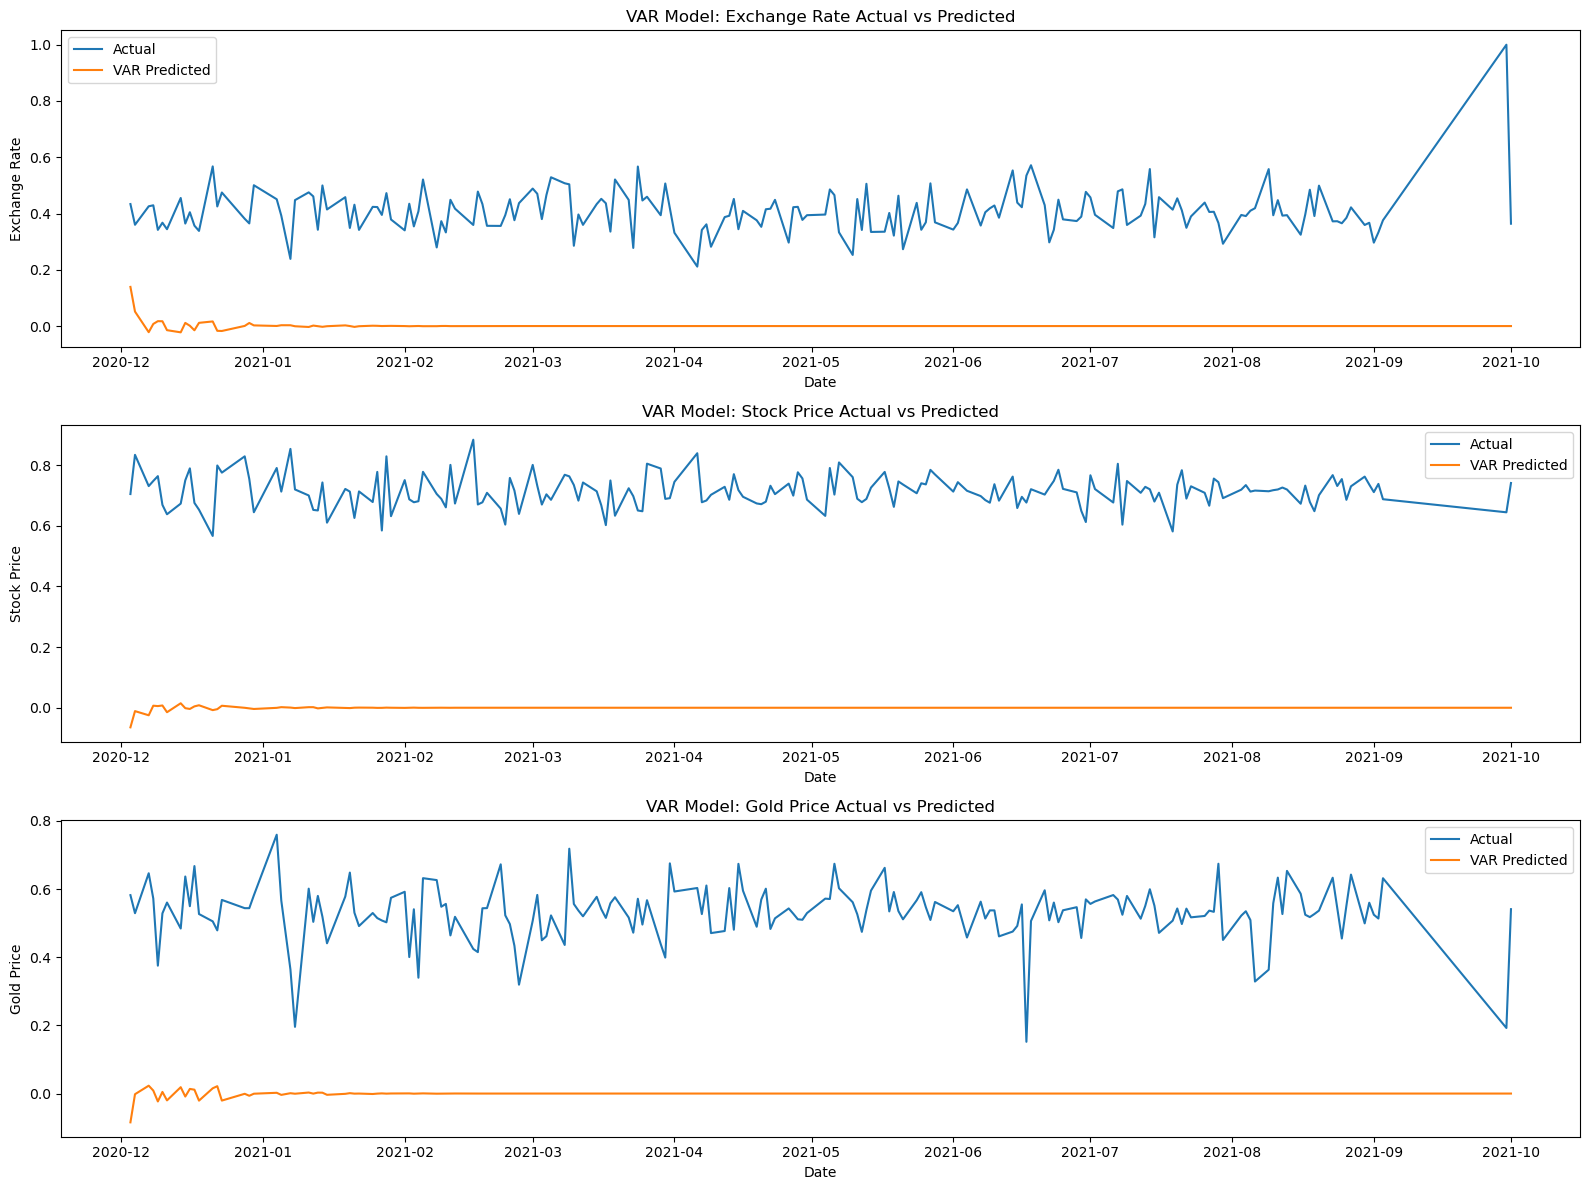

In [28]:
for i, column in enumerate(train.columns, 1):
    plt.subplot(3, 1, i)
    plt.plot(test.index, test[column], label='Actual')
    plt.plot(test.index, var_pred_df[column], label='VAR Predicted')
    plt.title(f'VAR Model: {column} Actual vs Predicted')
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.legend()

plt.tight_layout()
plt.show()

In [33]:


# Function to check stationarity
def test_stationarity(timeseries):
    adf_test = adfuller(timeseries, autolag='AIC')
    print(f'ADF Statistic: {adf_test[0]}')
    print(f'p-value: {adf_test[1]}')
    return adf_test[1] <= 0.05 

train_diff = train.diff().dropna()
test_diff = test.diff().dropna()

for column in train_diff.columns:
    print(f"\nStationarity test for {column} after differencing")
    is_stationary = test_stationarity(train_diff[column])
    print(f'{column} is stationary: {is_stationary}')


model = VAR(train_diff)
lag_order = model.select_order(maxlags=20)
print(lag_order.summary())

var_model = model.fit(lag_order.aic)
print(var_model.summary())

# Forecast using the VAR model
var_pred_diff = var_model.forecast(train_diff.values[-lag_order.aic:], steps=len(test))

var_pred = train.values[-1] + var_pred_diff.cumsum(axis=0)
var_pred_df = pd.DataFrame(var_pred, index=test.index, columns=train.columns)



Stationarity test for Exchange Rate after differencing
ADF Statistic: -14.681553074730427
p-value: 3.15028005168917e-27
Exchange Rate is stationary: True

Stationarity test for Stock Price after differencing
ADF Statistic: -13.442691391619483
p-value: 3.817706332505507e-25
Stock Price is stationary: True

Stationarity test for Gold Price after differencing
ADF Statistic: -14.997314192037189
p-value: 1.1028217259204216e-27
Gold Price is stationary: True
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -13.63      -13.62   1.200e-06      -13.63
1       -14.57      -14.53   4.691e-07      -14.56
2       -14.96      -14.89   3.184e-07      -14.93
3       -15.11      -15.01   2.730e-07      -15.08
4       -15.23      -15.10   2.432e-07      -15.18
5       -15.30      -15.14   2.266e-07      -15.24
6       -15.38      -15.19   2.101e-07      -15.31
7       -15.42      -15.20   2.0

/Users/suman/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


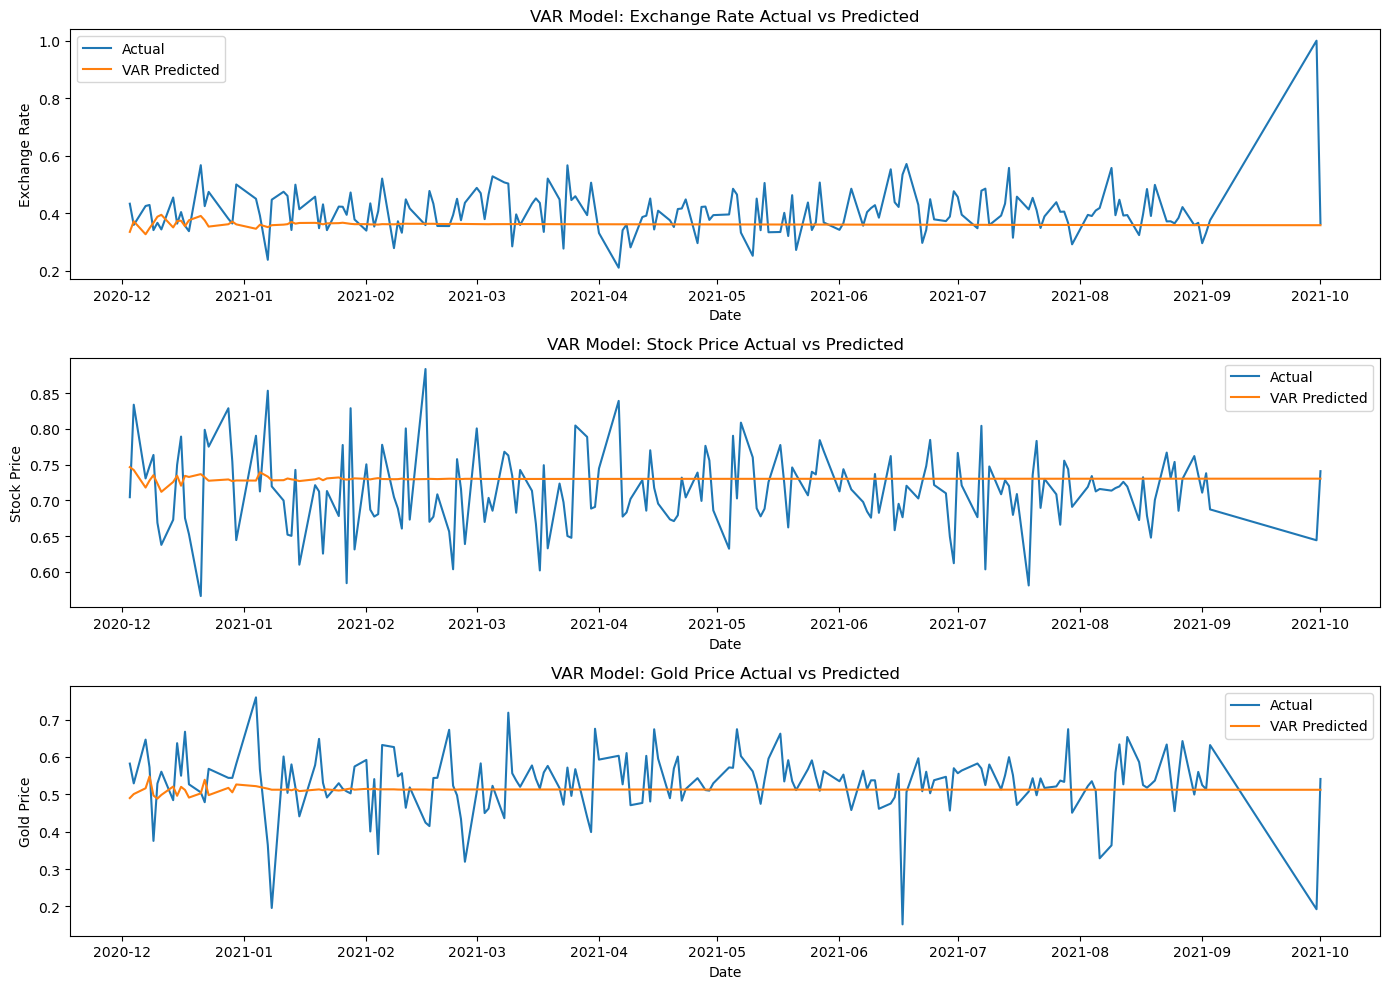

In [34]:
# plot optimized VAR
plt.figure(figsize=(14, 10))

for i, column in enumerate(train.columns, 1):
    plt.subplot(3, 1, i)
    plt.plot(test.index, test[column], label='Actual')
    plt.plot(test.index, var_pred_df[column], label='VAR Predicted')
    plt.title(f'VAR Model: {column} Actual vs Predicted')
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.legend()

plt.tight_layout()
plt.show()

In [35]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Prepare the data
scaler_lstm = MinMaxScaler()
scaled_data_lstm = scaler_lstm.fit_transform(data_scaled[['Exchange Rate', 'Stock Price', 'Gold Price']])


X_lstm, y_lstm = [], []
for i in range(len(scaled_data_lstm) - 1):
    X_lstm.append(scaled_data_lstm[i])
    y_lstm.append(scaled_data_lstm[i + 1])
X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

# Split the data into training and test sets for lstm
train_size_lstm = int(len(X_lstm) * 0.9)
X_train_lstm, X_test_lstm = X_lstm[:train_size_lstm], X_lstm[train_size_lstm:]
y_train_lstm, y_test_lstm = y_lstm[:train_size_lstm], y_lstm[train_size_lstm:]

# Reshape 
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], 1, X_train_lstm.shape[1]))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], 1, X_test_lstm.shape[1]))

# LSTM model architecture
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model_lstm.add(Dense(3))  # 3 output neurons for 3 columns
model_lstm.compile(optimizer='adam', loss='mse')

# Train the LSTM model
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=100, batch_size=64, verbose=1)

# Evaluate the LSTM model
lstm_pred = model_lstm.predict(X_test_lstm)
lstm_rmse = mean_squared_error(y_test_lstm, lstm_pred, squared=False)
print('LSTM RMSE:', lstm_rmse)




2024-06-09 16:40:24.628347: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-06-09 16:40:24.628366: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-06-09 16:40:24.628371: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-06-09 16:40:24.628423: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-09 16:40:24.628625: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100


2024-06-09 16:40:25.159764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


26/26 [==============================] - 1s 12ms/step - loss: 0.2954
Epoch 2/100
26/26 [==============================] - 0s 9ms/step - loss: 0.2181
Epoch 3/100
26/26 [==============================] - 0s 8ms/step - loss: 0.1377
Epoch 4/100
26/26 [==============================] - 0s 8ms/step - loss: 0.0639
Epoch 5/100
26/26 [==============================] - 0s 8ms/step - loss: 0.0213
Epoch 6/100
26/26 [==============================] - 0s 8ms/step - loss: 0.0083
Epoch 7/100
26/26 [==============================] - 0s 10ms/step - loss: 0.0069
Epoch 8/100
26/26 [==============================] - 0s 8ms/step - loss: 0.0068
Epoch 9/100
26/26 [==============================] - 0s 8ms/step - loss: 0.0068
Epoch 10/100
26/26 [==============================] - 0s 8ms/step - loss: 0.0068
Epoch 11/100
26/26 [==============================] - 0s 8ms/step - loss: 0.0068
Epoch 12/100
26/26 [==============================] - 0s 8ms/step - loss: 0.0068
Epoch 13/100
26/26 [===========================

2024-06-09 16:40:47.354575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


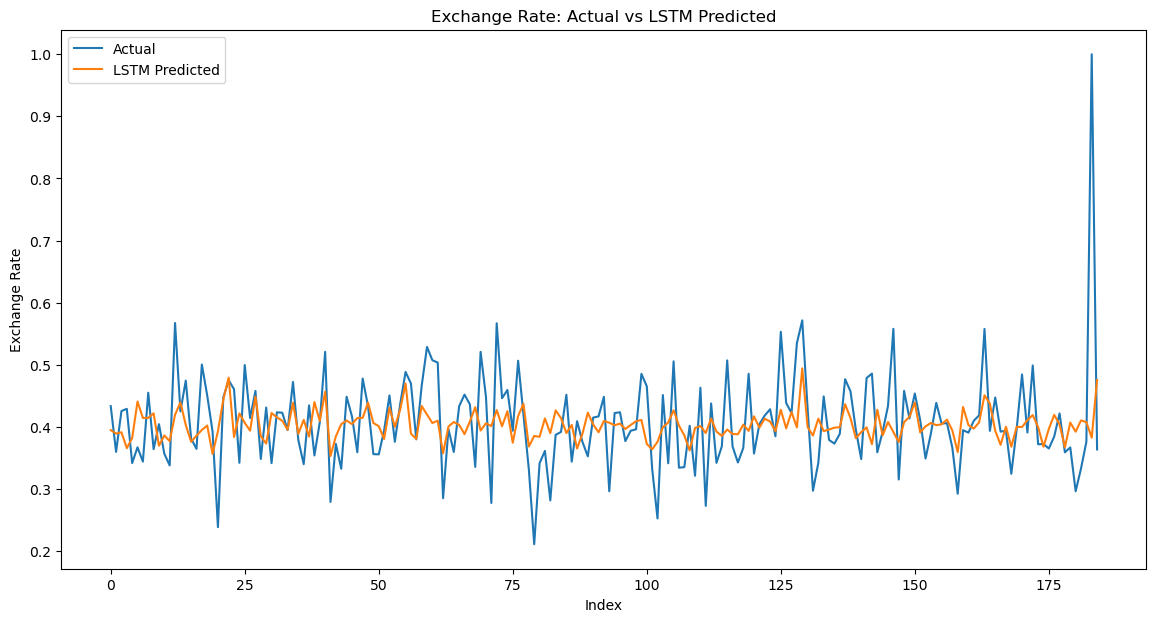

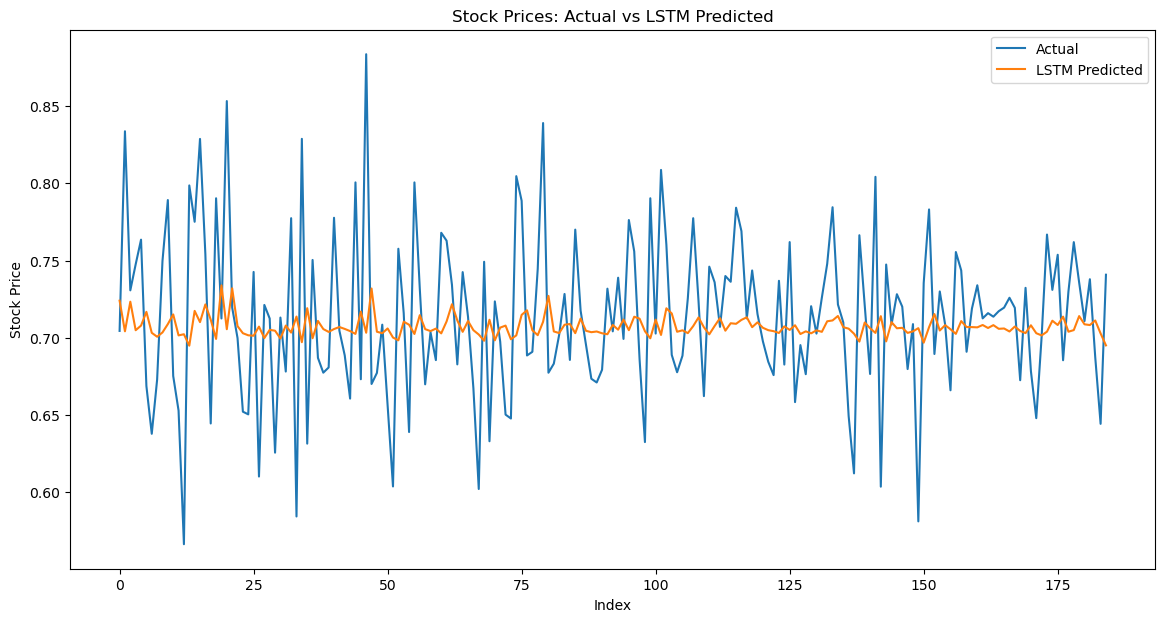

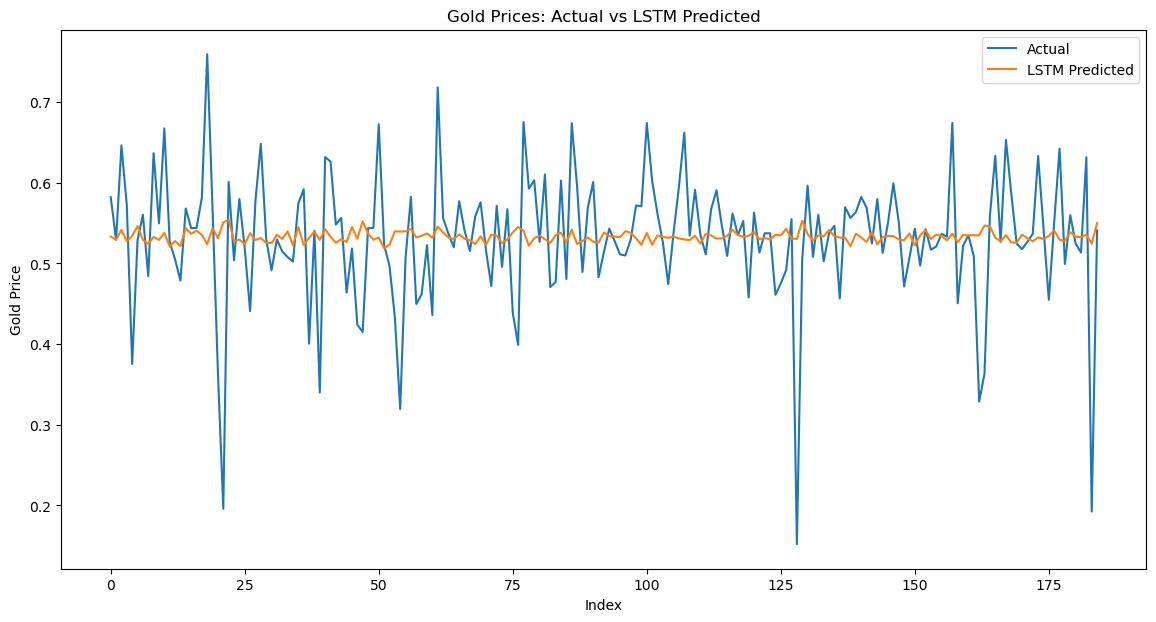

In [36]:
# Visualize the results
plt.figure(figsize=(14, 7))
plt.plot(y_test_lstm[:, 0], label='Actual')
plt.plot(lstm_pred[:, 0], label='LSTM Predicted')
plt.title('Exchange Rate: Actual vs LSTM Predicted')
plt.xlabel('Index')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(y_test_lstm[:, 1], label='Actual')
plt.plot(lstm_pred[:, 1], label='LSTM Predicted')
plt.title('Stock Prices: Actual vs LSTM Predicted')
plt.xlabel('Index')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(y_test_lstm[:, 2], label='Actual')
plt.plot(lstm_pred[:, 2], label='LSTM Predicted')
plt.title('Gold Prices: Actual vs LSTM Predicted')
plt.xlabel('Index')
plt.ylabel('Gold Price')
plt.legend()
plt.show()

### Hyperparameter tuning and Granger Causality

In [37]:
from statsmodels.tsa.stattools import grangercausalitytests

# Granger causality test 
max_lag = 12
for col in train.columns:
    if col != 'Exchange Rate':
        print(f'\nGranger Causality Test for {col} causing Exchange Rate:')
        granger_test = grangercausalitytests(train[['Exchange Rate', col]], max_lag, verbose=True)



Granger Causality Test for Stock Price causing Exchange Rate:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=39.2195 , p=0.0000  , df_denom=1658, df_num=1
ssr based chi2 test:   chi2=39.2905 , p=0.0000  , df=1
likelihood ratio test: chi2=38.8330 , p=0.0000  , df=1
parameter F test:         F=39.2195 , p=0.0000  , df_denom=1658, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=20.0251 , p=0.0000  , df_denom=1655, df_num=2
ssr based chi2 test:   chi2=40.1712 , p=0.0000  , df=2
likelihood ratio test: chi2=39.6928 , p=0.0000  , df=2
parameter F test:         F=20.0251 , p=0.0000  , df_denom=1655, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=13.6334 , p=0.0000  , df_denom=1652, df_num=3
ssr based chi2 test:   chi2=41.0734 , p=0.0000  , df=3
likelihood ratio test: chi2=40.5732 , p=0.0000  , df=3
parameter F test:         F=13.6334 , p=0.0000  , df_denom=1652, df_num=3

Granger Causality
number

/Users/suman/env/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/suman/env/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [43]:
# Check the shape of the input arrays
print("X_train_lstm shape:", X_train_lstm.shape)
print("X_test_lstm shape:", X_test_lstm.shape)


X_train_lstm shape: (1661, 1, 3)
X_test_lstm shape: (185, 1, 3)


In [54]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np


train_size_lstm = int(len(X_lstm) * 0.9)
X_train_lstm, X_test_lstm = X_lstm[:train_size_lstm], X_lstm[train_size_lstm:]
y_train_lstm, y_test_lstm = y_lstm[:train_size_lstm], y_lstm[train_size_lstm:]

# Reshape input data for LSTM model
X_train_lstm_opt = X_train_lstm.reshape((X_train_lstm.shape[0], 1, X_train_lstm.shape[1]))
X_test_lstm_opt = X_test_lstm.reshape((X_test_lstm.shape[0], 1, X_test_lstm.shape[1]))



Epoch 1/100


2024-06-09 17:46:09.229499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


26/26 [==============================] - 1s 12ms/step - loss: 0.2062
Epoch 2/100
26/26 [==============================] - 0s 8ms/step - loss: 0.1392
Epoch 3/100
26/26 [==============================] - 0s 8ms/step - loss: 0.0744
Epoch 4/100
26/26 [==============================] - 0s 8ms/step - loss: 0.0356
Epoch 5/100
26/26 [==============================] - 0s 9ms/step - loss: 0.0263
Epoch 6/100
26/26 [==============================] - 0s 12ms/step - loss: 0.0236
Epoch 7/100
26/26 [==============================] - 0s 10ms/step - loss: 0.0208
Epoch 8/100
26/26 [==============================] - 0s 9ms/step - loss: 0.0177
Epoch 9/100
26/26 [==============================] - 0s 10ms/step - loss: 0.0145
Epoch 10/100
26/26 [==============================] - 0s 9ms/step - loss: 0.0113
Epoch 11/100
26/26 [==============================] - 0s 9ms/step - loss: 0.0083
Epoch 12/100
26/26 [==============================] - 0s 8ms/step - loss: 0.0057
Epoch 13/100
26/26 [=========================

2024-06-09 17:46:31.578281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


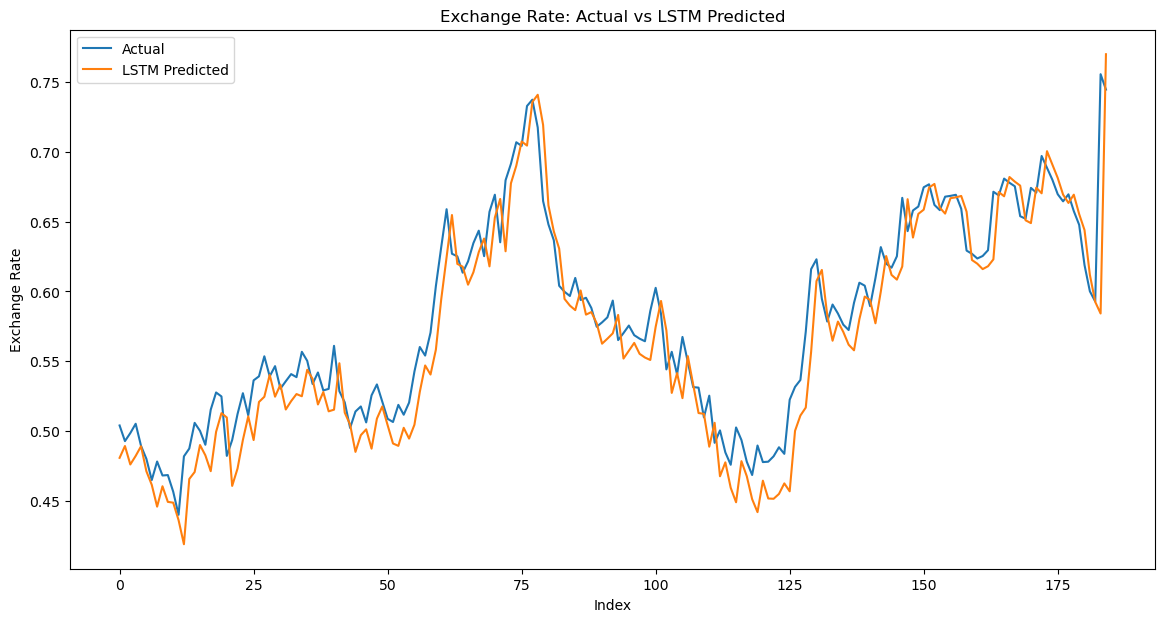

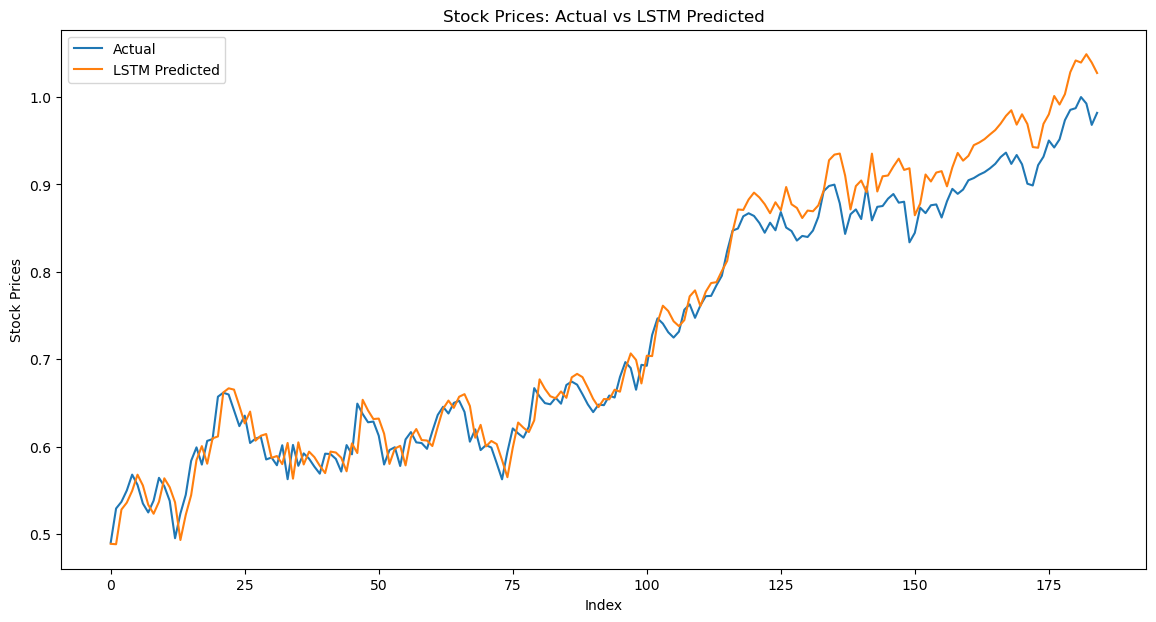

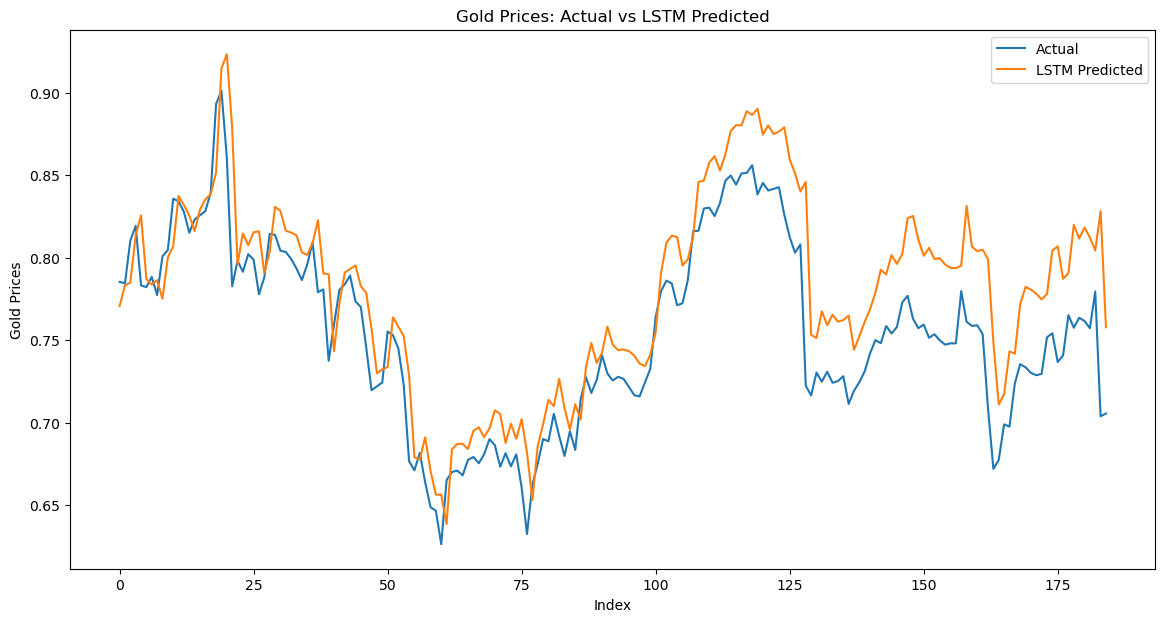

In [61]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Prepare the data
scaler_lstm = MinMaxScaler()
scaled_data_lstm = scaler_lstm.fit_transform(df[['Exchange Rate', 'Stock Price', 'Gold Price']])

# Split data into input features (X) and target variable (y)
X_lstm, y_lstm = [], []
for i in range(len(scaled_data_lstm) - 1):
    X_lstm.append(scaled_data_lstm[i])
    y_lstm.append(scaled_data_lstm[i + 1])
X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

# Split the data into training and test sets
train_size_lstm = int(len(X_lstm) * 0.9)
X_train_lstm, X_test_lstm = X_lstm[:train_size_lstm], X_lstm[train_size_lstm:]
y_train_lstm, y_test_lstm = y_lstm[:train_size_lstm], y_lstm[train_size_lstm:]

# Reshape input data for LSTM model
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], 1, X_train_lstm.shape[1]))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], 1, X_test_lstm.shape[1]))


model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model_lstm.add(Dense(3)) 
model_lstm.compile(optimizer='adam', loss='mse')

# Train the LSTM model
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=100, batch_size=64, verbose=1)

# Evaluate the LSTM model
lstm_pred = model_lstm.predict(X_test_lstm)
lstm_rmse = mean_squared_error(y_test_lstm, lstm_pred, squared=False)
print('LSTM RMSE:', lstm_rmse)

# Visualize the results
plt.figure(figsize=(14, 7))
plt.plot(y_test_lstm[:, 0], label='Actual')
plt.plot(lstm_pred[:, 0], label='LSTM Predicted')
plt.title('Exchange Rate: Actual vs LSTM Predicted')
plt.xlabel('Index')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(y_test_lstm[:, 1], label='Actual')
plt.plot(lstm_pred[:, 1], label='LSTM Predicted')
plt.title('Stock Prices: Actual vs LSTM Predicted')
plt.xlabel('Index')
plt.ylabel('Stock Prices')
plt.legend()
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(y_test_lstm[:, 2], label='Actual')
plt.plot(lstm_pred[:, 2], label='LSTM Predicted')
plt.title('Gold Prices: Actual vs LSTM Predicted')
plt.xlabel('Index')
plt.ylabel('Gold Prices')
plt.legend()
plt.show()



In [76]:
from sklearn.metrics import mean_squared_error
# Evaluate VAR model
var_rmse = {}
for i, column in enumerate(['Exchange Rate', 'Stock Price', 'Gold Price']):
    actual_values = test[column]
    forecast_values = var_pred_diff[:, i]
    var_rmse[column] = np.sqrt(mean_squared_error(actual_values, forecast_values))

print('VAR RMSE:')
for column, rmse in var_rmse.items():
    print(f'{column}: {rmse}')



VAR RMSE:
Exchange Rate: 0.4153382363203646
Stock Price: 0.7160565727860491
Gold Price: 0.538125240345788


In [77]:
# Exogenous variables
exog_train = train[['Exchange Rate', 'Gold Price']]  
exog_test = test[['Exchange Rate', 'Gold Price']]  

# Fit the SARIMAX model 
model = SARIMAX(train['Stock Price'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), exog=exog_train)
sarimax_model = model.fit(disp=False)

# Forecast the values for the test period
sarimax_preds = sarimax_model.get_forecast(steps=len(test), exog=exog_test)
sarimax_forecast = sarimax_preds.predicted_mean

# Calculate RMSE for the 'Stock Prices' column
actual_values = test['Stock Price']
rmse = np.sqrt(mean_squared_error(actual_values, sarimax_forecast))
print('SARIMAX RMSE:', rmse)


print('LSTM RMSE:', lstm_rmse)

/Users/suman/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suman/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/suman/env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX RMSE: 0.05346462896360761
LSTM RMSE: 0.030244125158812668


/Users/suman/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/suman/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
